In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
# Uninstall the Watson Machine Learning client Python client based on v3 APIs

!pip uninstall watson-machine-learning-client -y

Uninstalling watson-machine-learning-client-1.0.380:
  Successfully uninstalled watson-machine-learning-client-1.0.380


In [3]:
# Install WML client API

!pip install ibm-watson-machine-learning

In [4]:
from ibm_watson_machine_learning import APIClient

In [5]:
# Instantiate a client using credentials
# You may want to change the URL depending on the instance you are using.
wml_credentials = {
      "apikey": "teuonH42NK9fs-h2kbKROGBHhiirxc6tFhyXQ7eIOcgg",
      "url": "https://us-south.ml.cloud.ibm.com"
}

client = APIClient(wml_credentials)

In [6]:
client.version

'1.0.8'

## Fetching dataset

In [7]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_650cc1d3bf7248f79d930ae78332efcc = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='g2Yb3rm3Qu12tHBTLmZttpvnebyAyHcLQnmgiDqql_HM',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_650cc1d3bf7248f79d930ae78332efcc.get_object(Bucket='myml-donotdelete-pr-4mvgvcm1hbtnsk',Key='tickets_dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_tickets = pd.read_csv(body)
df_tickets.head()

,title,body,category,category_description
0,NaN,hi since recruiter lead permission approve req...,4,Asset access
1,connection with icon,icon dear please setup icon per icon engineers...,6,Network
2,work experience user,work experience user hi work experience studen...,5,Software Purchase or Upgrade
3,requesting for meeting,requesting meeting hi please help follow equip...,5,Software Purchase or Upgrade
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,4,Asset access


In [8]:
# Feature Matrix and Target Vector
X = df_tickets['body']
y = df_tickets['category_description']

In [9]:
# Split the dataset into training and test dataset in 80:20 ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Tokenization and TF IDF

In [10]:
# Convert the text into word counts

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
# Convert the word count vector into Term frequency - Inverse Document Frequency vector

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

## Training and evaluating accuracy of different classification models

In [12]:
# Dictionary of classfiers

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

clf_dict = { 'Gaussian': MultinomialNB(), 
             'Support Vector Machine': SVC(kernel='linear'), 
             'Decision Tree': DecisionTreeClassifier(), 
             'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0), 
             'Stochastic Gradient Descent': SGDClassifier(max_iter=5, tol=-np.infty, random_state=42),
             'K Nearest Neighbor': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform')
           }

In [13]:
# Iterate through dictionary of classifiers, fit pipeline and find the accuracy

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

for key, value in clf_dict.items():
    print(key)
    text_clf = Pipeline([('vectorizer',count_vectorizer),('tfidf', tfidf_transformer),('clf',value)])
    %time text_clf.fit(X_train, y_train)
    y_pred = text_clf.predict(X_test)
    print("Accuracy: ",accuracy_score(y_test, y_pred))
    print("------------------------------------------")

Gaussian
CPU times: user 1.32 s, sys: 52 ms, total: 1.37 s
Wall time: 1.49 s
Accuracy:  0.8126480585024204
------------------------------------------
Support Vector Machine
CPU times: user 4min 11s, sys: 936 ms, total: 4min 12s
Wall time: 4min 12s
Accuracy:  0.855803893294881
------------------------------------------
Decision Tree
CPU times: user 50.8 s, sys: 8 ms, total: 50.8 s
Wall time: 50.8 s
Accuracy:  0.7838088371613966
------------------------------------------
Random Forest
CPU times: user 1min 8s, sys: 200 ms, total: 1min 9s
Wall time: 1min 9s
Accuracy:  0.8345864661654135
------------------------------------------
Stochastic Gradient Descent
CPU times: user 1.66 s, sys: 8 ms, total: 1.67 s
Wall time: 1.67 s
Accuracy:  0.8413842826243692
------------------------------------------
K Nearest Neighbor
CPU times: user 1.26 s, sys: 4 ms, total: 1.26 s
Wall time: 1.26 s
Accuracy:  0.8363374188896899
------------------------------------------


In [14]:
# We selected SGD Classifier based on training time and accuracy

text_clf = Pipeline([('vectorizer',count_vectorizer),('tfidf', tfidf_transformer),('clf',SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))])
%time text_clf.fit(X_train, y_train)

CPU times: user 1.69 s, sys: 16 ms, total: 1.71 s
Wall time: 1.71 s


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...dom_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False))])

In [15]:
# Predictions on test dataset

y_pred = text_clf.predict(X_test)
y_pred.shape

(9709,)

## Model Evaluation

In [16]:
# Classification metrics

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                                  precision    recall  f1-score   support

                    Asset access       0.85      0.97      0.90      6835
              Backup or Recovery       0.96      0.57      0.72        40
Hardware Addition or Replacement       0.00      0.00      0.00        19
               Hardware Purchase       1.00      0.03      0.06        31
               Manual Correction       0.00      0.00      0.00         1
                         Network       0.66      0.19      0.30       529
                  Password Reset       0.00      0.00      0.00         9
             Premise Access Card       0.68      0.53      0.60       312
    Software Purchase or Upgrade       0.83      0.66      0.74      1926
                  Summary Report       1.00      0.14      0.25         7

                       micro avg       0.84      0.84      0.84      9709
                       macro avg       0.60      0.31      0.36      9709
                    weighted avg    

In [17]:
# Distinct categories

categories = np.unique(y_train.values)
categories

array(['Asset access', 'Backup or Recovery',
       'Hardware Addition or Replacement', 'Hardware Purchase',
       'Manual Correction', 'Network', 'Password Reset',
       'Premise Access Card', 'Software Purchase or Upgrade',
       'Summary Report'], dtype=object)

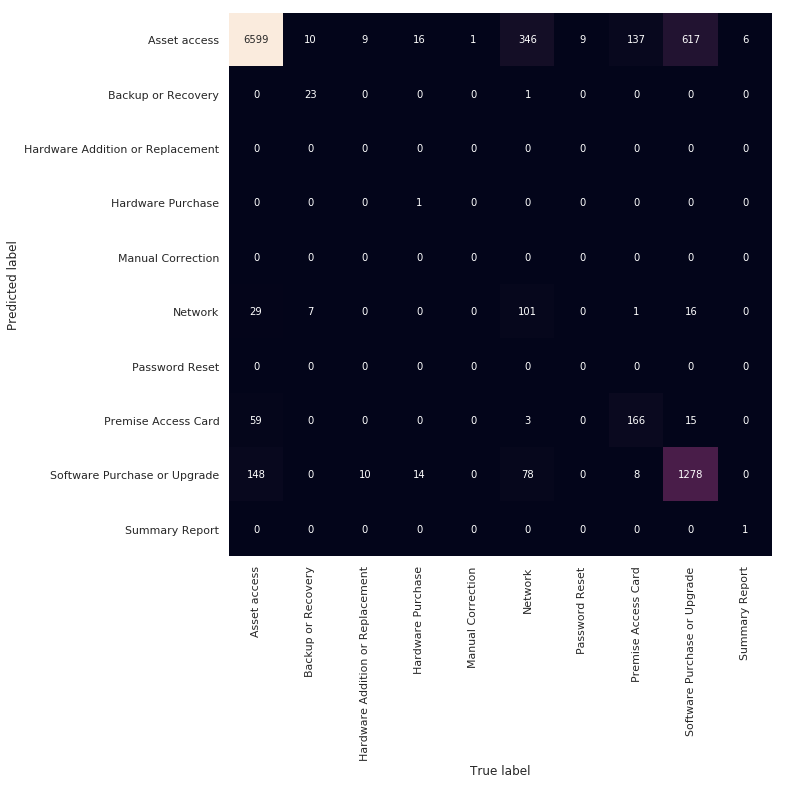

In [18]:
# Heatmap

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, ax=ax, xticklabels=categories, yticklabels=categories)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

## Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'clf__max_iter': [5, 50, 100],
              'clf__tol': [-np.infty, 1e-10, 1e-3]}
grid = GridSearchCV(text_clf, param_grid)

%time grid.fit(X_train, y_train)
    
print(grid.best_params_)

CPU times: user 1min 31s, sys: 716 ms, total: 1min 32s
Wall time: 1min 32s
{'clf__max_iter': 5, 'clf__tol': -inf}


## Testing unseen data

In [20]:
X_test_unseen = ['Please puchase hardware for my system','Please provide me access to floor','Add me to Network']

In [21]:
y_test_unseen = text_clf.predict(X_test_unseen)
y_test_unseen

array(['Software Purchase or Upgrade', 'Premise Access Card',
       'Asset access'], dtype='<U32')

## Saving model

In [22]:
df_tickets_unseen = pd.DataFrame({'body':X_test_unseen, 'category':y_test_unseen})
df_tickets_unseen

,body,category
0,Please puchase hardware for my system,Software Purchase or Upgrade
1,Please provide me access to floor,Premise Access Card
2,Add me to Network,Asset access


In [23]:
%mkdir model

In [24]:
%%writefile model/main.py

from docplex.util.environment import get_environment
from os.path import splitext
import pandas
from six import iteritems

def write_all_outputs(outputs):
    for (name, df) in iteritems(outputs):
        csv_file = '%s.csv' % name
        print(csv_file)
        with get_environment().get_output_stream(csv_file) as fp:
            if sys.version_info[0] < 3:
                fp.write(df.to_csv(index=False, encoding='utf8'))
            else:
                fp.write(df.to_csv(index=False).encode(encoding='utf8'))
    if len(outputs) == 0:
        print("Warning: no outputs written")

Writing model/main.py


In [25]:
%%writefile -a model/main.py

write_all_outputs(dt_tickets_unseen)

Appending to model/main.py


In [26]:
import tarfile
def reset(tarinfo):
    tarinfo.uid = tarinfo.gid = 0
    tarinfo.uname = tarinfo.gname = "root"
    return tarinfo
tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model/main.py", arcname="main.py", filter=reset)
tar.close()

In [27]:
# All available meta data properties 

client.repository.ModelMetaNames.show()

------------------------  ----  --------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
META_PROP NAME            TYPE  REQUIRED  SCHEMA
NAME                      str   Y
DESCRIPTION               str   N
INPUT_DATA_SCHEMA         list  N         {'id(required)': 'string', 'fields(required)': [{'name(required)': 'string', 'type(required)': 'string', 'nullable(optional)': 'string'}]}
TRAINING_DATA_REFERENCES  list  N         [{'name(optional)': 'string', 'type(required)': 'string', 'connection(required)': {'endpoint_url(required)': 'string', 'access_key_id(required)': 'string', 'secret_access_key(required)': 'string'},

In [28]:
space_id = 'f6f6501f-c8e1-4c4f-9c65-59ecafdcc386'
print(space_id)

f6f6501f-c8e1-4c4f-9c65-59ecafdcc386


In [29]:
client.set.default_space(space_id)

'SUCCESS'

In [30]:
ticket_classifier_metadata = {
    client.repository.ModelMetaNames.NAME: "TicketCategoryClassifier",
    client.repository.ModelMetaNames.DESCRIPTION: "Model for Ticket Classification",
    client.repository.ModelMetaNames.TYPE: "scikit-learn_0.22",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: client.software_specifications.get_uid_by_name('scikit-learn_0.22-py3.6')
}

model_details = client.repository.store_model(text_clf, meta_props=ticket_classifier_metadata)

model_uid = client.repository.get_model_uid(model_details)

print("Model UID: ",model_uid)

Model UID:  9ca56be4-7517-4c8c-ac02-3625c3d8c101


## Deployment

In [31]:
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "TicketCategoryClassifier Deployment",
    client.deployments.ConfigurationMetaNames.DESCRIPTION: "Deployment of Model for Ticket Classification",
    client.deployments.ConfigurationMetaNames.BATCH: {},
    client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: {'name': 'S', 'nodes': 1}
}

deployment_details = client.deployments.create(model_uid, meta_props=meta_props)

deployment_uid = client.deployments.get_uid(deployment_details)

print( deployment_uid )



#######################################################################################

Synchronous deployment creation for uid: '9ca56be4-7517-4c8c-ac02-3625c3d8c101' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='fd67aabb-a3c0-41a9-92c7-8591881a0c5f'
------------------------------------------------------------------------------------------------


fd67aabb-a3c0-41a9-92c7-8591881a0c5f


In [32]:
# List all existing deployments

client.deployments.list()

------------------------------------  ------------------------------------  -----  ------------------------
GUID                                  NAME                                  STATE  CREATED
fd67aabb-a3c0-41a9-92c7-8591881a0c5f  TicketCategoryClassifier Deployment   ready  2020-09-06T12:09:18.078Z
f9a273fc-79cb-4c29-b4c0-2c3d2960e938  Deployment of trade prediction model  ready  2020-09-06T11:27:17.718Z
7faa31c0-7fa2-41d2-b0da-b93a685c3d95  TicketCategoryClassifier Deployment   ready  2020-09-06T10:44:02.347Z
------------------------------------  ------------------------------------  -----  ------------------------
